<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Electric-Power-Consumption-in-[GWh/a]" data-toc-modified-id="Electric-Power-Consumption-in-[GWh/a]-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Electric Power Consumption in [GWh/a]</a></span></li><li><span><a href="#Gas-consumption-in-[MWh/a]" data-toc-modified-id="Gas-consumption-in-[MWh/a]-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gas consumption in [MWh/a]</a></span></li></ul></div>

# Show the disaggregator overview

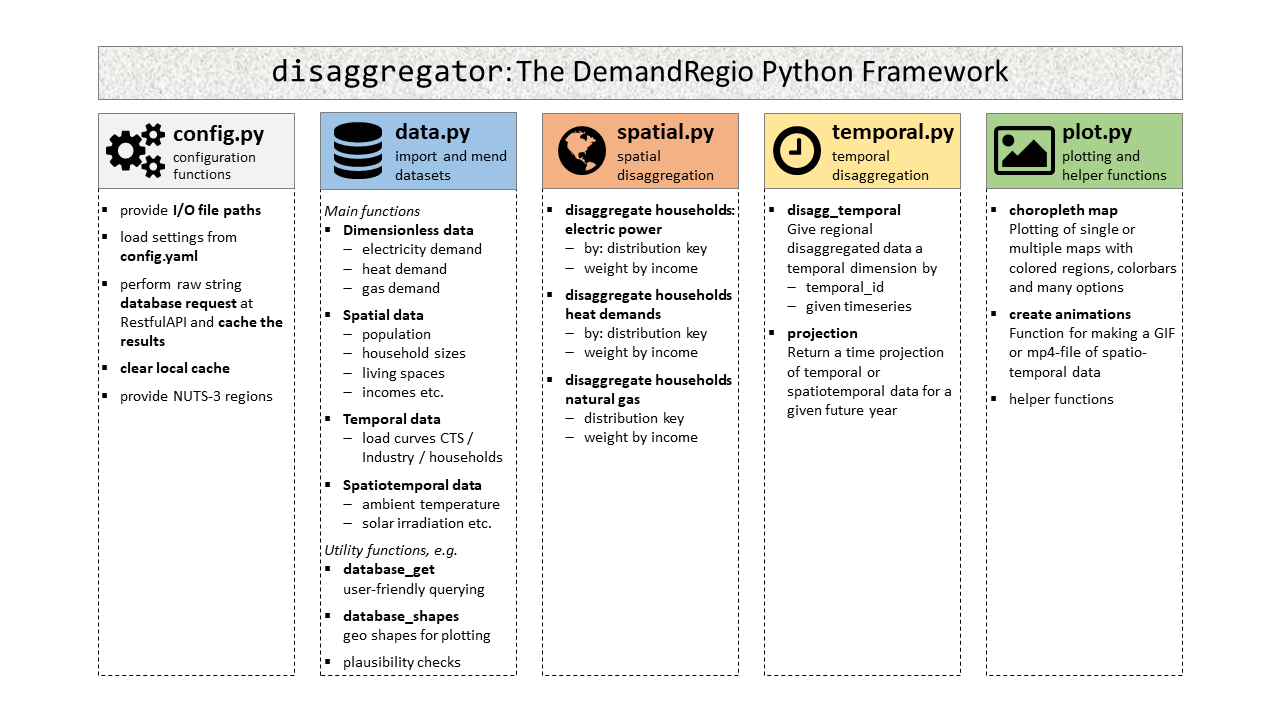

In [1]:
from IPython.display import Image
pic = Image(filename=('./img/overview.png'))
pic

# Spatial disaggregation with `spatial.py`

Now, as we've gathered a spatial feeling for the relevant input data in the first notebook, let's take a look at the spatial disaggregation abilities.

In [1]:
import pandas as pd
from disaggregator import config, data, spatial, plot

## Electric Power Consumption in [GWh/a]

The disaggregation method for the electric power consumption of private households is `spatial.disagg_households_power()` and requires at least one argument:

1. ``by`` is the distribution key and must be one of ``['population', 'households']``.  

    Using ``population`` invokes a *top-down*-method, i.e. the overall electricity consumption of entire Germany is being spread by distribution keys based on the population to calculate the consumption per region.  
    Using ``households`` invokes a *bottom-up*-method, i.e. the average electricity consumptions known for each household size are used for calculating the consumption per region.

Additionally, an income adjustment can be performed, through the switch ``weight_by_income=True``.

Let's start with ``population``:

In [2]:
ec_pop = spatial.disagg_households_power(by='population', weight_by_income=False)
ec_pop.head()

2023-10-02 14:30:33 disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/demandregio_spatial?id_spatial=eq.2&&year=eq.2015&&value=gt.0.0
2023-10-02 14:30:34 disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/v_demandregio_spatial_lk401?id_spatial=eq.1&&year=eq.2015&&value=gt.0.0


nuts3
DE111    1001.919449
DE112     612.457232
DE113     841.912846
DE114     405.994406
DE115     857.890857
Name: value, dtype: float64

... and continue with ``households``:

In [3]:
ec_hh = spatial.disagg_households_power(by='households', weight_by_income=False)
ec_hh.head()

2023-10-02 14:30:41 disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/demandregio_spatial?id_spatial=eq.13&&value=gt.0.0


hh_size           1           2           3           4          5          6
nuts3                                                                        
DE111    287.072910  277.795914  148.683780  128.671440  52.705848  25.970568
DE112    116.986836  166.203012  102.229533  106.948720  40.849848  17.220840
DE113    175.966176  238.821170  139.949761  142.317510  51.318696  21.411936
DE114     76.646394  113.488486   70.962332   72.090295  27.499992  11.802648
DE115    173.487528  247.245632  136.440220  143.273825  51.211992  21.494928

So, do these two fundamentally different methods lead to comparable results? Let's check, by summing the consumptions of all six household types per region:

In [4]:
ec_hh.head().sum(axis=1)

nuts3
DE111    920.900460
DE112    550.438789
DE113    769.785249
DE114    372.490147
DE115    773.154125
dtype: float64

Okay, that seems comparable.  
Let's further check the results by plotting these side by side on *one* map. We can achieve this, by merging the results into one new ``pd.DataFrame`` :

In [5]:
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1)], keys=['population', 'households'], axis=1, join='inner')
ec_combined.head()

population  households
nuts3                         
DE111  1001.919449  920.900460
DE112   612.457232  550.438789
DE113   841.912846  769.785249
DE114   405.994406  372.490147
DE115   857.890857  773.154125

... and plot:

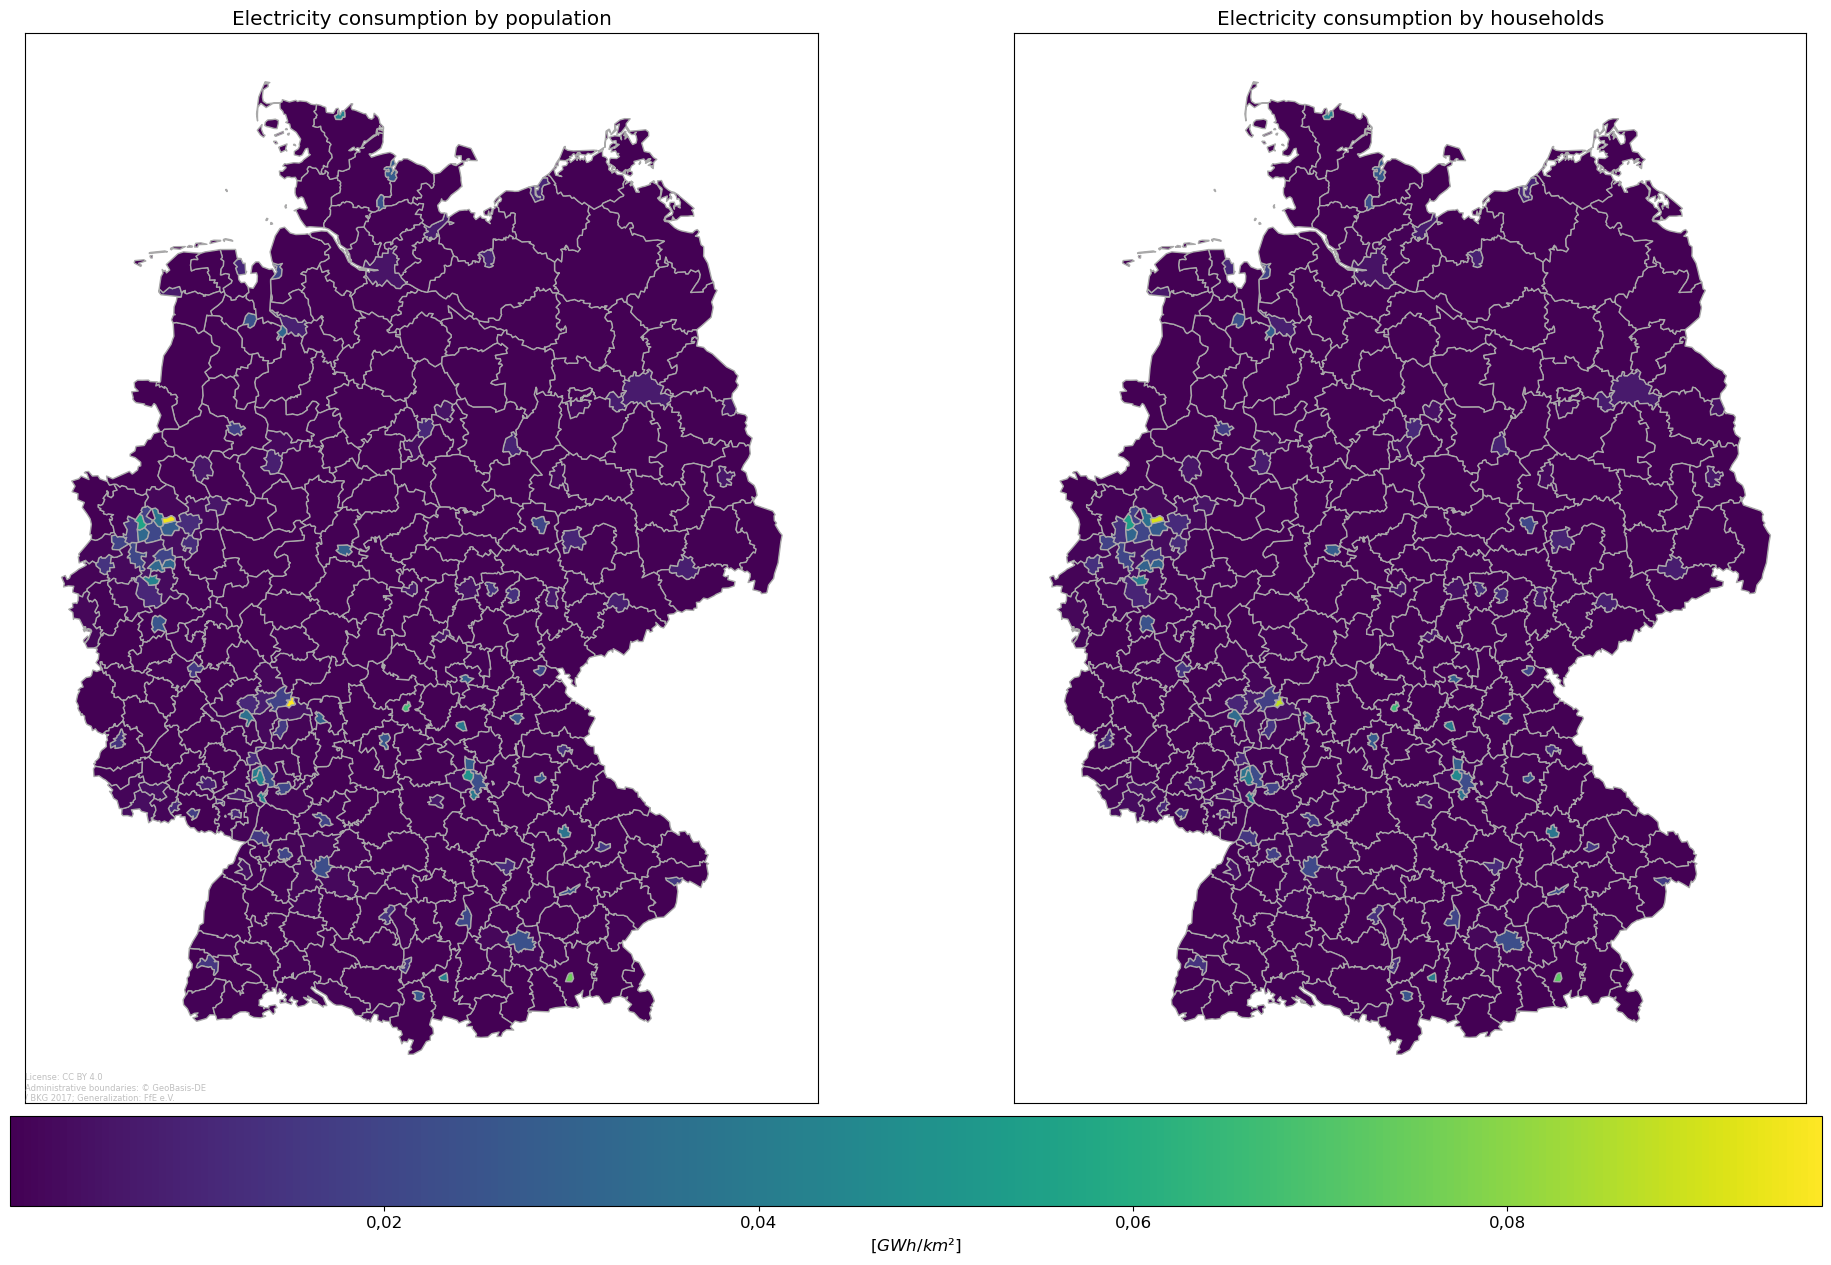

In [6]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh', axtitle='Electricity consumption by', add_percentages=False)

Now let's weight the consumptions by the available income:

In [7]:
ec_pop_ic = spatial.disagg_households_power(by='population', weight_by_income=True)
ec_hh_ic = spatial.disagg_households_power(by='households', weight_by_income=True)
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1), ec_pop_ic, ec_hh_ic.sum(axis=1)],
                        keys=['population', 'households', 'population (weighted)', 'households (weighted)'],
                        axis=1, join='inner')

2023-10-02 14:31:04 disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/v_demandregio_spatial_lk401?id_spatial=eq.45&&year=eq.2015&&internal_id=eq.{2}&&value=gt.0.0


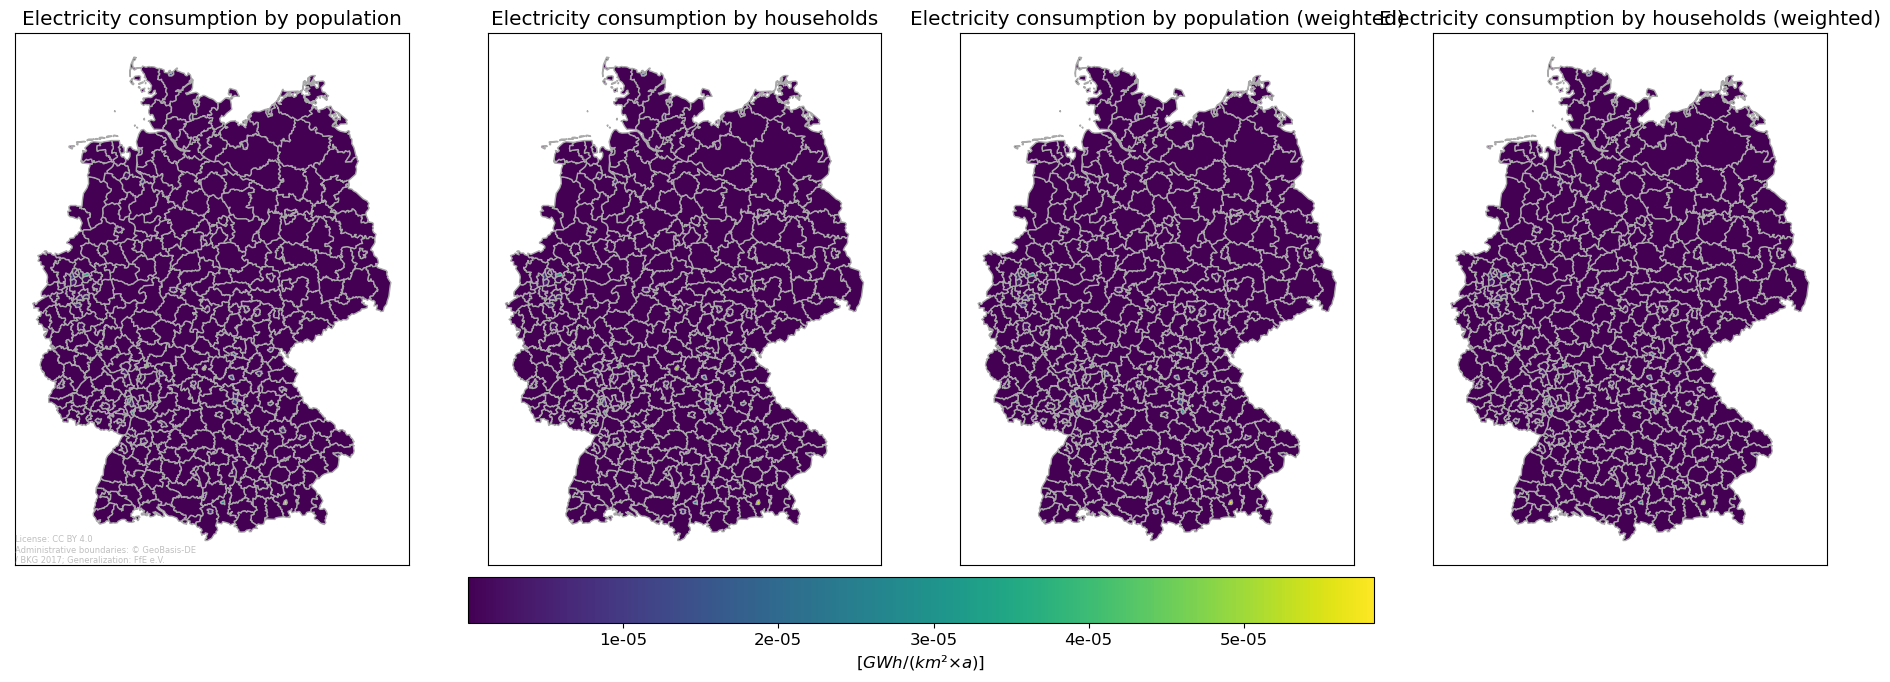

In [8]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh/a', axtitle='Electricity consumption by',
                              add_percentages=False, figsize=(20,12), nrows=1, ncols=4)

Now save this figure e.g. as PDF file:

In [11]:
from disaggregator.config import data_out
fig.savefig(data_out('disagg_households_power.pdf'), bbox_inches='tight')

## Gas consumption in [MWh/a]

The gas demands of private households are threefold:
1. cooking (=process heat)
2. warm water
3. space heating

The first two ones depend mainly on the **household size**, whereas the latter depends mainly on the **size of the building**. However, centralized space heating systems are very often also used as boilers for the hot water supply.

In [9]:
df_gas_td = spatial.disagg_households_gas(how='top-down')
df_gas_td.head()

2023-10-02 14:31:45 disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/demandregio_spatial?id_spatial=eq.35&&year=eq.2015&&value=gt.0.0
2023-10-02 14:31:46 disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/v_demandregio_spatial_lk401?id_spatial=eq.12&&year=eq.2018&&value=gt.0.0
2023-10-02 14:32:13 disaggregator.spatial: INFO     Calculating regional gas demands top-down.


Cooking       HotWater  SpaceHeating
nuts3                                          
DE111  8154.428882  337979.140588  9.619266e+05
DE112  4499.408917  206601.208685  7.007097e+05
DE113  6402.718646  284003.849403  9.600965e+05
DE114  3032.327011  136954.762744  5.137948e+05
DE115  6427.189209  289393.738285  1.033030e+06

In [10]:
df_gas_bu = spatial.disagg_households_gas(how='bottom-up')
df_gas_bu.head()

2023-10-02 14:32:30 disaggregator.spatial: INFO     Calculating regional gas demands bottom-up.
2023-10-02 14:32:43 disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/v_demandregio_spatial_lk401?id_spatial=eq.56&&year=eq.2018&&value=gt.0.0


Cooking       HotWater   SpaceHeating
nuts3                                           
DE111  8154.428882  337979.140588  848858.277006
DE112  4499.408917  206601.208685  715476.269692
DE113  6402.718646  284003.849403  931479.321340
DE114  3032.327011  136954.762744  501044.405876
DE115  6427.189209  289393.738285  963624.305592

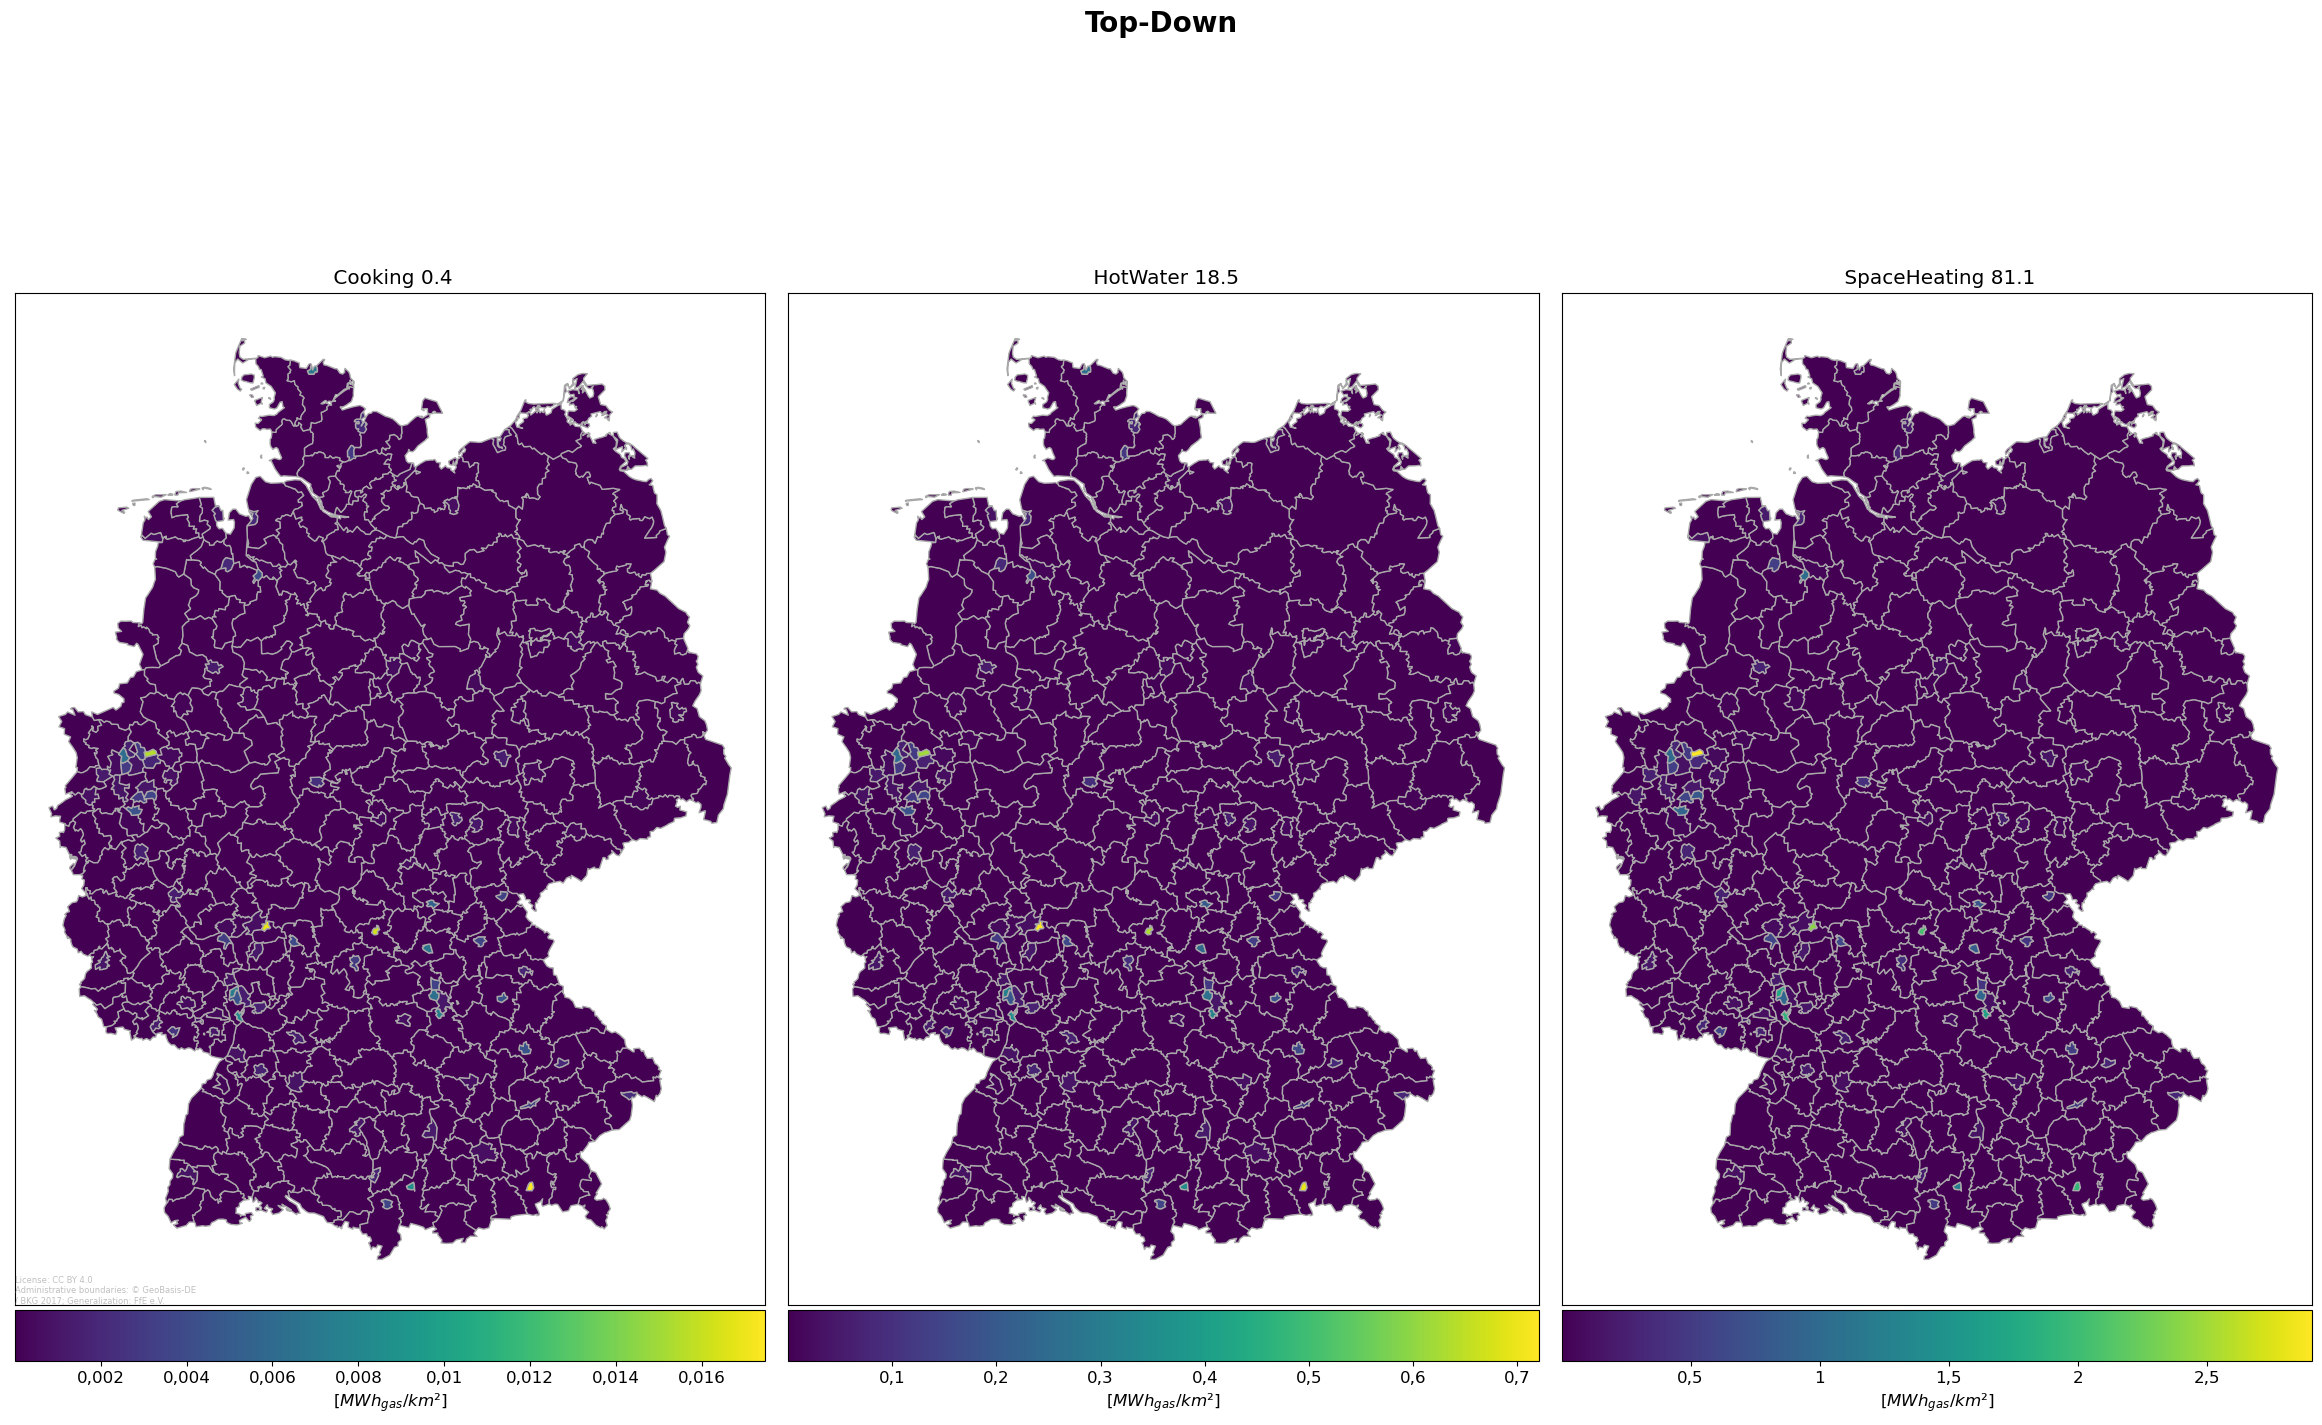

In [11]:
fig, ax = plot.choropleth_map(df_gas_td, unit='MWh_{gas}', colorbar_each_subplot=True, add_percentages=True, suptitle='Top-Down')

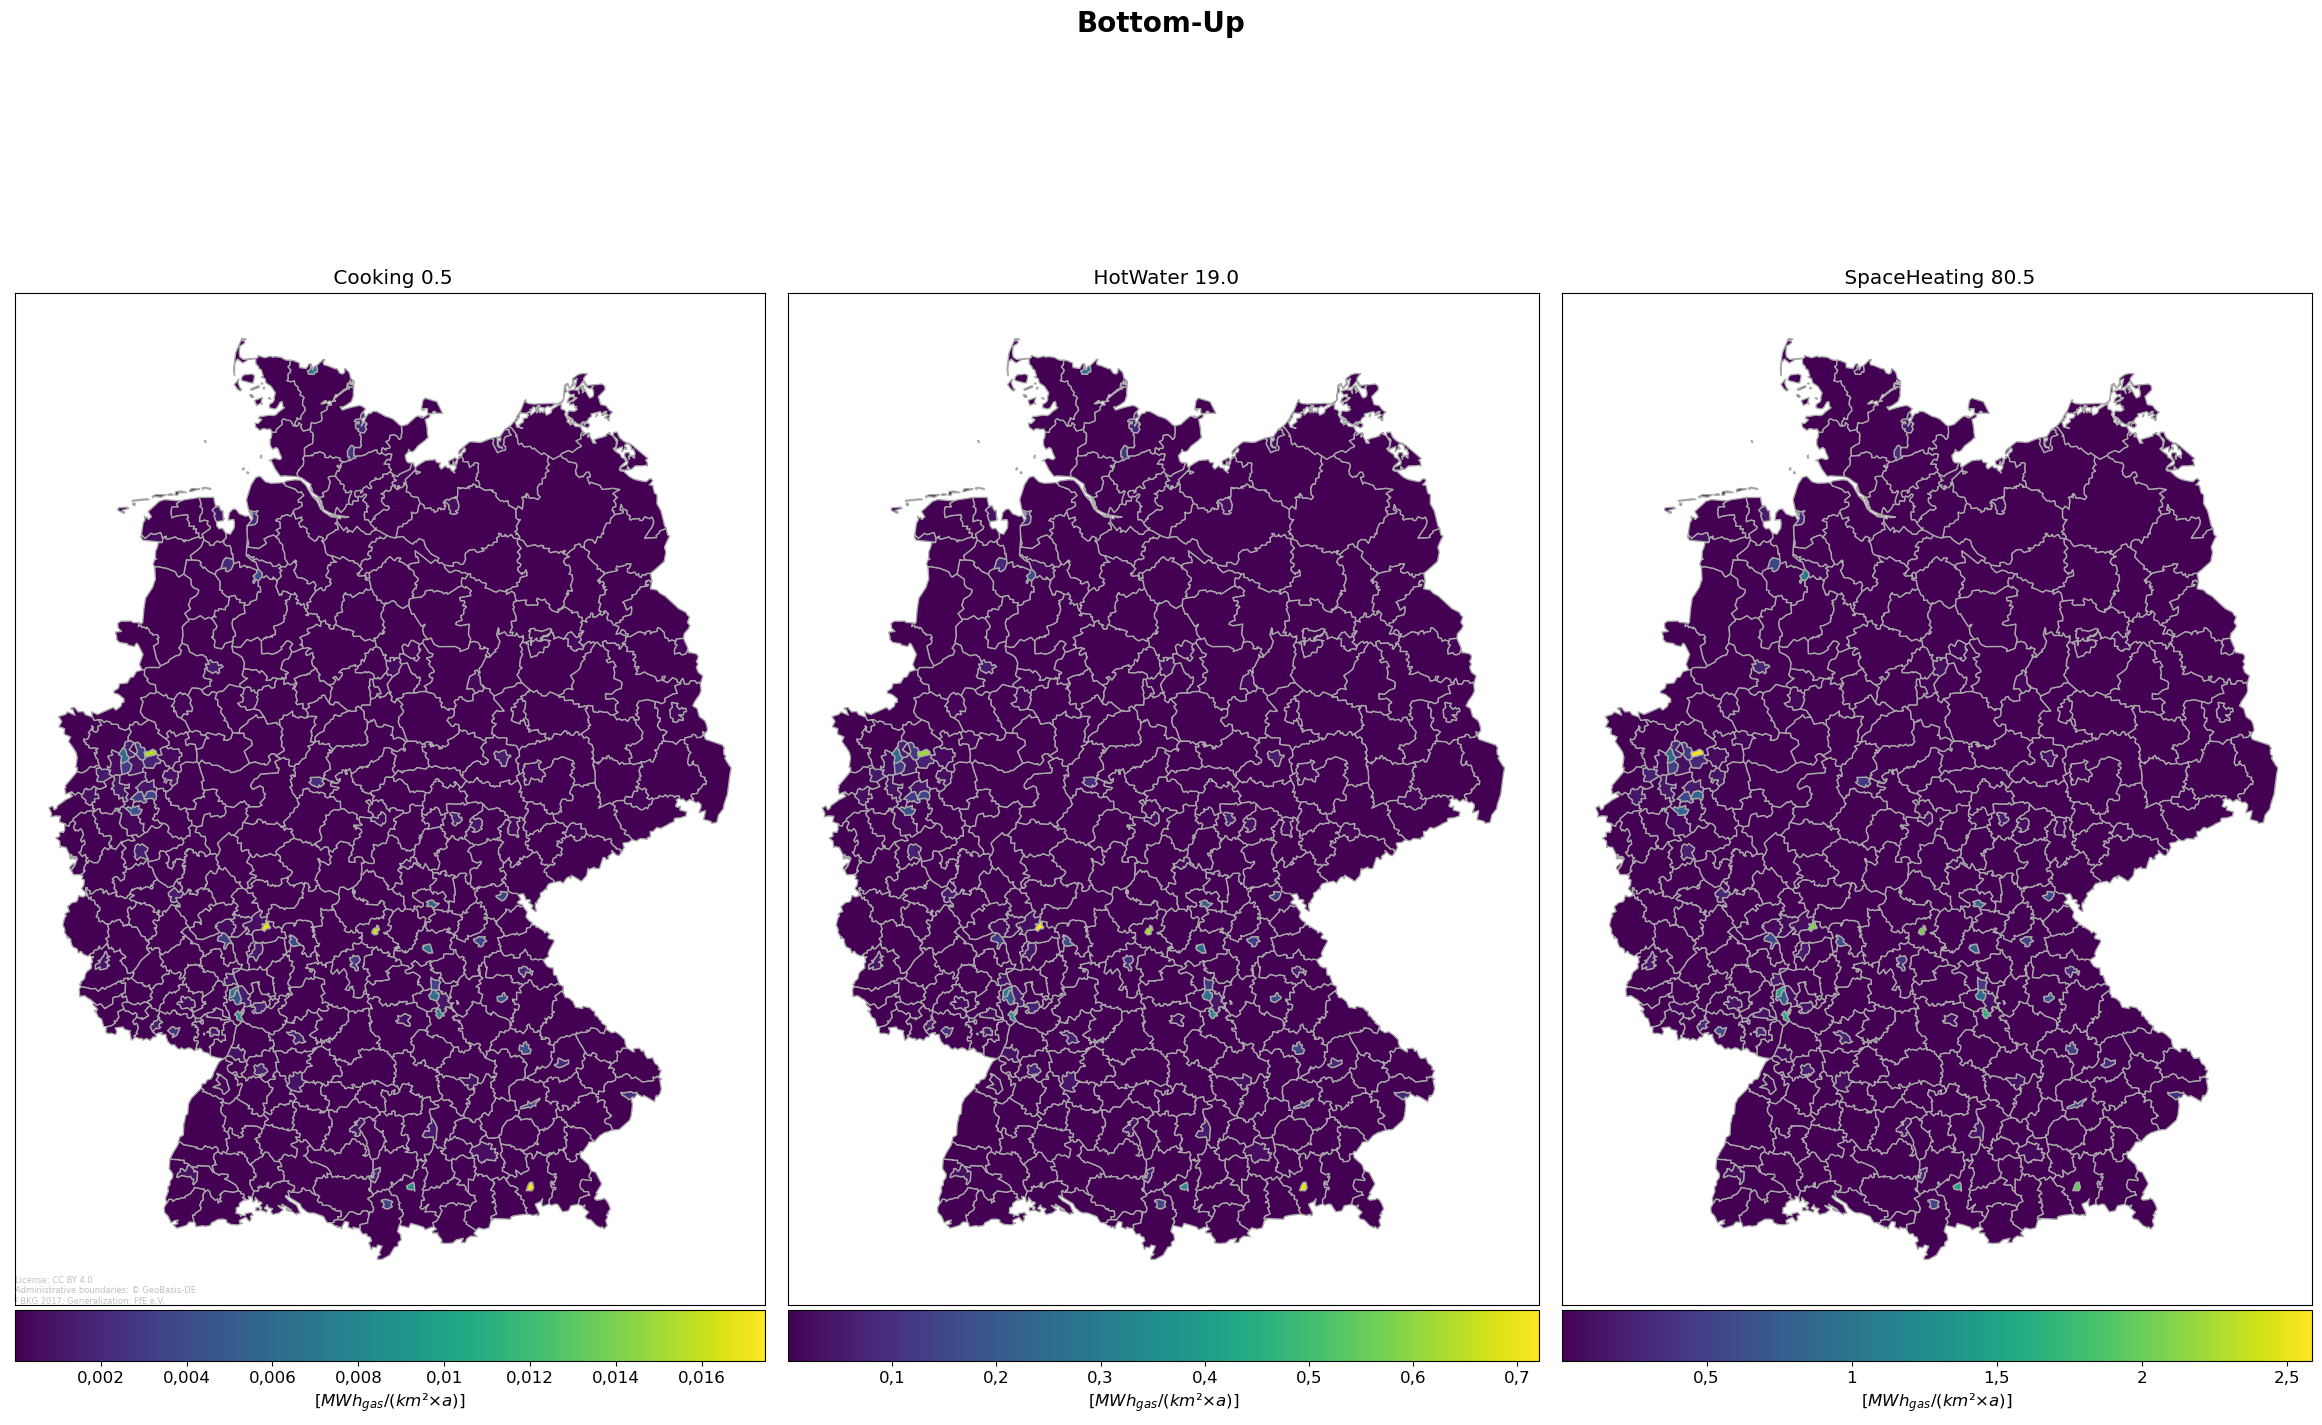

In [12]:
fig, ax = plot.choropleth_map(df_gas_bu, unit='MWh_{gas}/a', colorbar_each_subplot=True, add_percentages=True, suptitle='Bottom-Up')